In [2]:
import sys
import importlib
import gc
import glob
from itertools import combinations

import numpy as np
import jax
import jax.numpy as jnp
import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
import kmedoids

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

In [3]:
sns.set_theme(
    style="ticks",
    context="notebook",
    palette="colorblind",
    rc={"figure.figsize": (7, 6)},
)

Copied from https://github.com/emanuele/minibatch_kmeans/blob/master/kmeans.py 

In [4]:
def compute_labels(X, C):
    """Compute the cluster labels for dataset X given centers C."""
    # labels = np.argmin(pairwise_distances(C, X), axis=0) # THIS REQUIRES TOO MUCH MEMORY FOR LARGE X
    tree = KDTree(C)
    labels = tree.query(X, k=1, return_distance=False).squeeze()
    return labels

In [5]:
def compute_centroids(X, C):
    """Compute the centroids for dataset X given centers C. Note: centers
    C may not belong to X.
    """
    tree = KDTree(X)
    centroids = tree.query(C, k=1, return_distance=False).squeeze()
    return centroids

In [6]:
def mini_batch_kmeans(X, C, b, t, replacement=True):
    """The mini-batch k-means algorithms (Sculley et al. 2007) for the
    k-centers problem.
    X : data matrix
    C : initial centers
    b : size of the mini-batches
    t : number of iterations
    replacement: whether to sample batches with replacement or not.
    """
    C = C.copy()
    for i in range(t):
        # Sample a mini batch:
        if replacement:
            X_batch = X[np.random.choice(X.shape[0], b, replace=True)]
        else:
            X_batch = X[b * i : b * (i + 1)]

        V = np.zeros(C.shape[0])
        idxs = np.empty(X_batch.shape[0], dtype=np.int)
        # Assign the closest centers without update for the whole batch:
        for j, x in enumerate(X_batch):
            idxs[j] = np.argmin(((C - x) ** 2).sum(1))

        # Update centers:
        for j, x in enumerate(X_batch):
            V[idxs[j]] += 1
            eta = 1.0 / V[idxs[j]]
            C[idxs[j]] = (1.0 - eta) * C[idxs[j]] + eta * x

    return C

In [7]:
def kmpp(X, k):
    n_row, n_col = X.shape

    # randomly choose the first centroid
    centroids = np.zeros((k, n_col))
    rand_index = np.random.choice(n_row)
    centroids[0] = X[rand_index]

    # compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(
        X, [centroids[0]], metric="euclidean", n_jobs=-1
    ).flatten()

    for i in range(1, k):
        # choose the next centroid, the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid
        prob = distances ** 2
        rand_index = np.random.choice(n_row, size=1, p=prob / np.sum(prob))
        centroids[i] = X[rand_index]

        if i == k - 1:
            break

        # if we still need another cluster,
        # compute distances from the centroids to all data points
        # and update the squared distance as the minimum distance to all centroid
        distances_new = pairwise_distances(
            X, [centroids[i]], metric="euclidean", n_jobs=-1
        ).flatten()
        distances = np.min(np.vstack((distances, distances_new)), axis=0)
    return centroids

In [8]:
def mini_batch_kmeans_tmat(X, Xt, C, batch_size, tau, lmbda=0.5, max_iter=10):
    """The mini-batch k-means algorithms (Sculley et al. 2007) for the
    k-centers problem.
    X : list of trajectory data
    Xt : list of time-lagged trajectories
    C : initial centers
    tau: time lag (in number of frames)
    batch_size : size of the mini-batches (number of trajectories)
    lmbda : hyperparameter for weight of transition matrix loss
    max_iter : number of iterations
    """
    C = C.copy()
    k = len(C) # number of clusters
    n_trajs = len(X)
    assert n_trajs >= batch_size
    assert len(Xt) == n_trajs
    
    for i in range(max_iter):
        # Sample a mini batch:
        if replacement:
        indices = np.random.choice(n_trajs, batch_size, replace=False)
        X_batch = X[inds]
        Xt_batch = Xt[inds]
        X_batch_arr = jnp.concatenate(X_batch)
        Xt_batch_arr = jnp.concatenate(Xt_batch)
        
        V = jnp.zeros(k)
#         idxs = np.empty(X_batch_arr.shape[0], dtype=np.int)
        # Assign the closest centers without update for the whole batch:
        idxs = compute_labels(X_batch_arr, C)

        # Update centers:
        update = jnp.zeros_like(C)
        for j, x in enumerate(X_batch):
            V[idxs[j]] += 1
            update[idxs[j]] += (x - C[idxs[j]])
            
        # learning rate           
        eta = 1.0 / V[idxs[j]]
        grad_tmat_loss
#         for i, c in enumerate(C):
        # compute gradient wrt centroids
        grad_tmat_loss[i] = grad_tmat_loss(C, X_batch, Xt_batch, tau=tau)
        C -= eta * ((1 - lmbda) * update + lmbda * grad_tmat_loss) 

    return C

In [123]:
def _tmat_loss(C, X, Xt, tau):
    """
    X : list of trajectory data
    Xt : list of time-lagged trajectory data
    C : centroids against which to compute loss
    """
    #     loss = 0

    for traj, traj_lagged in zip(fake_X, fake_Xt):
        # find closest centroid
        idx = np.zeros(len(traj), dtype=np.int)
        idx_t = np.zeros(len(traj_lagged), dtype=np.int)
        for i, (x, xt) in enumerate(zip(traj, traj_lagged)):
            idx[i] = jnp.argmin(jnp.linalg.norm(x - C, axis=1))
            idx_t[i] = jnp.argmin(jnp.linalg.norm(xt - C, axis=1))

        # convert to indicator function
        basis = np.zeros((len(traj), k))
        basis[np.arange(len(traj)), idx] += 1.0
        basist = np.zeros((len(traj), k))
        basist[np.arange(len(traj)), idx_t] += 1.0

        # compute loss
        tmat = jnp.matmul(
            jnp.linalg.inv(jnp.matmul(basis.T, basis)), jnp.matmul(basis.T, basist)
        )
    loss = 1 / (1 - jnp.diagonal(tmat))

    return np.sum(loss)

In [124]:
grad_tmat_loss = jax.grad(_tmat_loss, argnums=0, allow_int=True)

# testing

In [9]:
double_well_data = np.load("/project2/roux/scguo/toy_models/double_well.npy")
print(double_well_data.shape)

(200000000, 3)


In [10]:
# split into a bunch of short trajectories
trajs = [t[:, 1:] for t in np.split(double_well_data, 1000)]

In [11]:
trajs[0].shape

(200000, 2)

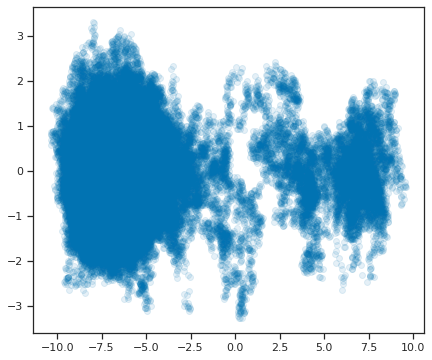

In [25]:
plt.scatter(*trajs[0].T, alpha=0.1)

In [30]:
X, Y = np.mgrid[-5:5, -5:5]
fake_data = np.vstack((X.flat, Y.flat)).T

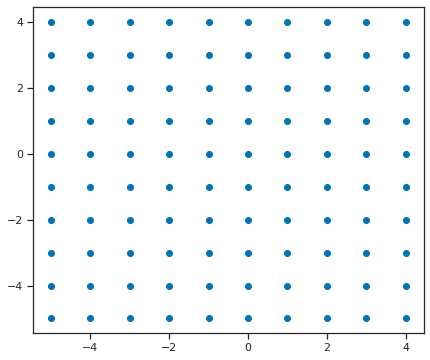

In [31]:
plt.scatter(*fake_data.T)

In [32]:
fake_data.shape

(100, 2)

In [51]:
C = np.array([[-4, 0], [4, 0]])

In [47]:
tau = 10
fake_X = [fake_data[:-tau]]
fake_Xt = [fake_data[tau:]]

In [44]:
import itertools

In [87]:
k = 2

In [109]:
for traj, traj_lagged in zip(fake_X, fake_Xt):
    # find closest centroid
    idx = np.zeros(len(traj), dtype=np.int)
    idx_t = np.zeros(len(traj_lagged), dtype=np.int)
    for i, (x, xt) in enumerate(zip(traj, traj_lagged)):
        idx[i] = jnp.argmin(jnp.linalg.norm(x - C, axis=1))
        idx_t[i] = jnp.argmin(jnp.linalg.norm(xt - C, axis=1))

    # convert to indicator function
    basis = np.zeros((len(traj), k))
    basis[np.arange(len(traj)), idx] += 1.0
    basist = np.zeros((len(traj), k))
    basist[np.arange(len(traj)), idx_t] += 1.0

    # compute loss
    tmat = jnp.matmul(
        jnp.linalg.inv(jnp.matmul(basis.T, basis)), jnp.matmul(basis.T, basist)
    )
loss = 1 / (1 - jnp.diagonal(tmat))

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np

In [103]:
jnp.linalg.norm(x - C, axis=0)

DeviceArray([7.071068, 5.656854], dtype=float32)

In [104]:
type(tmat)

jaxlib.xla_extension.DeviceArray

In [105]:
jnp.matmul(basis.T, basist)

DeviceArray([[50., 10.],
             [ 0., 30.]], dtype=float32)

In [110]:
jnp.linalg.inv(jnp.dot(basis.T, basis))

DeviceArray([[0.01666667, 0.        ],
             [0.        , 0.03333334]], dtype=float32)

In [111]:
tmat

DeviceArray([[0.8333334 , 0.16666667],
             [0.        , 1.        ]], dtype=float32)

In [94]:
loss

DeviceArray([5.9999995,       inf], dtype=float32)

In [71]:
x

array([3, 4])

In [72]:
C

array([[-4,  0],
       [ 4,  0]])

In [73]:
x - C

array([[ 7,  4],
       [-1,  4]])

In [77]:
jnp.argmin(jnp.linalg.norm(x - C, axis=1))

DeviceArray(1, dtype=int32)

In [85]:
print(idx)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [70]:
idx_t

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],            dtype=float32)

In [116]:
loss = _tmat_loss(C, fake_X, fake_Xt, tau)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

In [117]:
loss

DeviceArray([6.0000014,       inf], dtype=float32)

In [119]:
C

array([[-4,  0],
       [ 4,  0]])

In [125]:
grad_tmat_loss(C, fake_X, fake_Xt, tau)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

array([[(b'',), (b'',)],
       [(b'',), (b'',)]], dtype=[('float0', 'V')])